# Cyberbullying Detection
#### This is a cyberbullying detection website that detects if there is bullying and the type of bullying in a comment. Because the data is not clean, there are many pre processing steps that are needed in order to use it to train the model.

# Here is the link to the website ("https://hezron-like-bullying.streamlit.app/")

In [64]:
# !pip install pandas
# !pip install seaborn
# !pip install scikit-learn 
# !pip install missingno
# !pip install demoji
# !pip install langdetect
# !pip install regex
# !pip install wordcloud

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler 
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
import missingno as msno
from sklearn.utils import shuffle 
# from category_encoders import TargetEncoder, OneHotEncoder
import warnings
import re
import warnings
warnings.filterwarnings("ignore")

# Data Selection
#### the dataset is from kaggle (https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification), this dataset was chosen because it has a variety of bullying comments compared to other datasets. It also has a ideal number of comments in the dataset. The dataset is also suitable for NLP tasks because it requires a lot of preprocessing steps in order to train on it. 

In [3]:
df = pd.read_csv("C:/Users/Hezro/Desktop/cyberbullying_tweets.csv", encoding="iso-8859-1", low_memory=False)

In [4]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


# 1.0 Data Pre-processing

In [5]:
df['cyberbullying_type'].replace(['not_cyberbullying', 'gender', 'religion', 'age', 'ethnicity', 'other_cyberbullying'],
                        [0, 1, 2, 3, 4, 5], inplace=True)

In [6]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0
4,@RudhoeEnglish This is an ISIS account pretend...,0


## 1.1 Check for Null Values

In [7]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

## 1.2 Plot a graph to see the count of tweet for each cyberbullying_type

<Axes: xlabel='cyberbullying_type'>

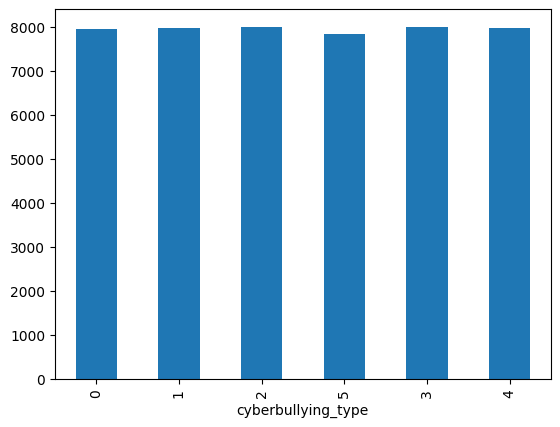

In [8]:
df.cyberbullying_type.value_counts()[df.cyberbullying_type.unique()].plot(kind='bar')

## 1.3 Check for duplicate values

In [9]:
df['tweet_text'].duplicated().sum()

np.int64(1675)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 745.3+ KB


In [11]:
df.drop_duplicates("tweet_text", inplace=True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46017 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          46017 non-null  object
 1   cyberbullying_type  46017 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


## 1.4 Removing Special Characters and Numbers

In [13]:
def remove_special_characters(txt):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', txt)
    return text

def remove_numbers(txt):
    # Using regex to substitute all numeric characters with an empty string
    text = re.sub(r'\d', '', txt)
    return text

## 1.5 Remove Emojis

In [14]:
import demoji
def remove_emojis(txt):
    return demoji.replace(txt, '')

## 1.6 Remove tweets that are not in English

In [15]:
from langdetect import detect, LangDetectException
def remove_nonEnglish_text(txt):
    try:
        lang = detect(txt)
    except LangDetectException:
        lang = "unknown"
    return txt if lang == "en" else ""

## 1.7 Remove words that are shorter than 3 letters

In [16]:
def remove_short_words(txt, min_len=3):
    words = txt.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

## 1.8 Remove tweets that are only 2 words or less

In [17]:
def remove_short_tweets(txt, min_words=4):
    words = txt.split()
    return txt if len(words) >= min_words else ""

## 1.9 Remove tweets that are more than 100 words

In [18]:
def remove_long_tweets(txt, max_words=100):
    words = txt.split()
    return txt if len(words) < max_words else ""

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46017 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          46017 non-null  object
 1   cyberbullying_type  46017 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


## 1.10 Remove URL

In [20]:
def remove_url(txt):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', txt)

## 1.11 Remove punctuation

In [21]:
import string
string.punctuation

def remove_punct(txt): 
    txt_nopunct = "".join([c for c in txt if c not in string.punctuation])
    return txt_nopunct

## 1.12 Tokenization

In [22]:
import re
def tokenize(txt): 
    tokens = re.split('\W+', txt)
    return tokens 

## 1.13 Stopwords Removal

In [23]:
# nltk.download('stopwords')

In [24]:
import nltk
from nltk.corpus import stopwords

",".join(stopwords.words('english'))
stopwords = nltk.corpus.stopwords.words('english')

In [25]:
#function to remove stopwords
def remove_stopwords(x): 
    return " ".join([word for word in str(x).split() if word not in stopwords])

## 1.14 Lemmatization

In [26]:
# nltk.download('wordnet')

In [27]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatization(txt):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in txt]
    return ' '.join(lemmatized_words)

## 1.15 Putting all pre-processing functions into one function

In [28]:
def finalClean_text(txt):
    txt = remove_special_characters(txt)
    txt = remove_numbers(txt)
    txt = remove_emojis(txt)
    txt = remove_nonEnglish_text(txt)
    txt = remove_short_words(txt)
    txt = remove_short_tweets(txt)
    txt = remove_long_tweets(txt)
    txt = remove_url(txt)
    txt = remove_punct(txt)
    txt = remove_stopwords(txt)
    txt = tokenize(txt)
    txt = lemmatization(txt)
    txt = ' '.join(txt.split())
    return txt

In [29]:
# df['tweet_text'] = [finalClean_text(txt) for txt in df['tweet_text']]
df['tweet_text'] = df['tweet_text'].apply(lambda x: finalClean_text(x))

In [30]:
df.head(50)

,tweet_text,cyberbullying_type
0,word katandandre food crapilicious mkr,0
1,Why aussietv white MKR theblock ImACelebrityAU...,0
2,XochitlSuckkks classy whore red velvet cupcake,0
3,JasonGio meh thanks head concerned another ang...,0
4,RudhoeEnglish This ISIS account pretending Kur...,0
5,Rajaaab Quickieleaks Yes test god good bad ind...,0
6,,0
7,Karma hope bite Kat butt She nasty mkr,0
8,stockputout everything mostly priest,0
9,Rebecca Black Drops Out School Due Bullying,0


## 1.16 Check for Duplicates (After Cleaning) 

In [31]:
df['tweet_text'].duplicated().sum()

np.int64(3687)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46017 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          46017 non-null  object
 1   cyberbullying_type  46017 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [33]:
df.drop_duplicates("tweet_text", inplace=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42330 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          42330 non-null  object
 1   cyberbullying_type  42330 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 992.1+ KB


In [35]:
df.head(50)

,tweet_text,cyberbullying_type
0,word katandandre food crapilicious mkr,0
1,Why aussietv white MKR theblock ImACelebrityAU...,0
2,XochitlSuckkks classy whore red velvet cupcake,0
3,JasonGio meh thanks head concerned another ang...,0
4,RudhoeEnglish This ISIS account pretending Kur...,0
5,Rajaaab Quickieleaks Yes test god good bad ind...,0
6,,0
7,Karma hope bite Kat butt She nasty mkr,0
8,stockputout everything mostly priest,0
9,Rebecca Black Drops Out School Due Bullying,0


## 1.17 Check for Imbalance (After Cleaning) 

<Axes: xlabel='cyberbullying_type'>

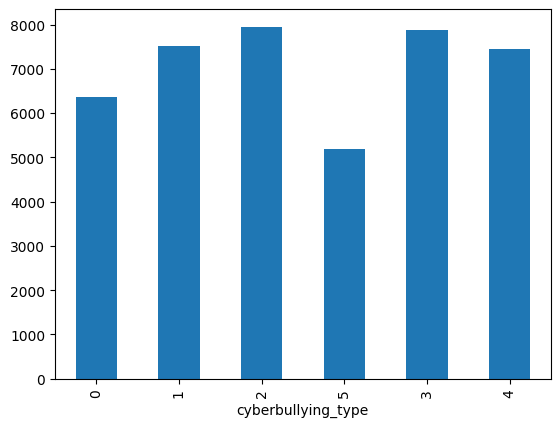

In [36]:
df.cyberbullying_type.value_counts()[df.cyberbullying_type.unique()].plot(kind='bar')

## 1.18 Word Cloud

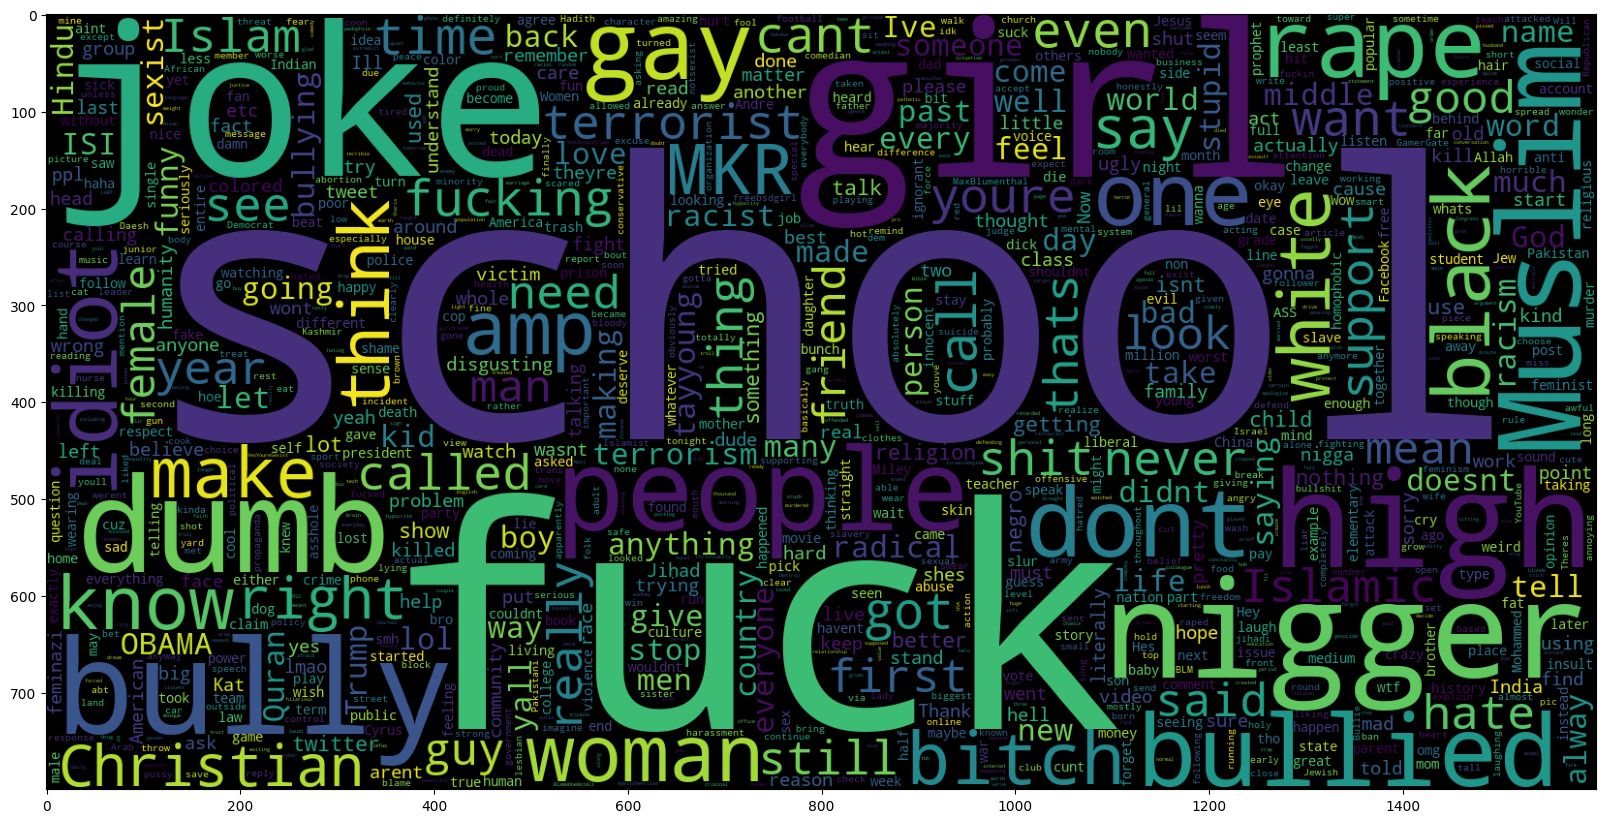

In [40]:
from wordcloud import WordCloud
plt.figure(figsize= (20,20))
wc = WordCloud(max_words=1000, width= 1600, height= 800, 
                collocations= False).generate(' '.join(df['tweet_text']))
plt.imshow(wc)

## 1.19 Splitting Train Test

In [41]:
df['t_textFinal'] = df['tweet_text']

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

t_text = df['t_textFinal']
c_type = df['cyberbullying_type']

X_train, X_test, y_train, y_test = train_test_split(t_text, c_type, test_size=0.2, random_state=42)

## 1.20 TFIDF

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data and transform the training data into a TF-IDF representation
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the test data into a TF-IDF representation
X_test_tfidf = vectorizer.transform(X_test)

## 1.21 SMOTE (Oversampling) 

In [46]:
# !pip install imblearn

In [47]:
from imblearn.over_sampling import SMOTE
vc = y_train.value_counts()
while (vc[0] != vc[4]) or (vc[0] !=  vc[2]) or (vc[0] !=  vc[3]) or (vc[0] !=  vc[1]):
    smote = SMOTE(sampling_strategy='minority')
    X_train_tfidf, y_train = smote.fit_resample(X_train_tfidf, y_train)
    vc = y_train.value_counts()

y_train.value_counts()

cyberbullying_type
0    6396
1    6396
3    6396
4    6396
2    6396
5    6396
Name: count, dtype: int64

# 2.0 Modelling

#### I have used about 4 total algorithms which are: Logistic Regression, SVM, Random Forest Classifier, Naive Byes. 

#### To measure the performance of each algorithm, the test accuracy will be used as well as the difference between the test and train accuracy to determine the presence of overfitting

#### For hyperparamter tuning
    SVM: kernel = 'linear', type of mathematical function used to transform data into a higher-dimensional space
         C = 1, A smaller 'C' allows more training errors, while a larger 'C' has a stricter margin, might lead to overfitting
         probability = 'True', to provide probability of the output
         
    Random Forest Classifier: 'n_estimators = 100', the number of decision trees to be built in the model

## 2.1 Logistic Regression

### 2.1.1 Train Dataset Results

In [48]:
# # Initialize and train a classifier (e.g., Logistic Regression) using the TF-IDF representation
# logReg = LogisticRegression(max_iter=1000)
# logReg.fit(X_train_tfidf, y_train)

# # Evaluate the performance of the classifier
# accuracy = logReg.score(X_train_tfidf, y_train)
# print("Accuracy:", accuracy)

### 2.1.2 Test Data Results

In [49]:
# # Predict on the test data
# y_pred = logReg.predict(X_test_tfidf)

# # Evaluate the performance of the classifier
# accuracy = logReg.score(X_test_tfidf, y_test)
# print("Accuracy:", accuracy)

## 2.2 SVM

### Train Data Results

In [50]:
from sklearn.svm import SVC
svm_model_linear = SVC(kernel= 'linear', C = 1, probability = True)
svm_model_linear.fit(X_train_tfidf, y_train)
accuracy = svm_model_linear.score(X_train_tfidf, y_train)
print("Accuracy:", accuracy)

Accuracy: 0.9641181988742964


### Test Data Results

In [51]:
# svm_predictions  = svm_model_linear.predict(X_test_tfidf)
accuracy = svm_model_linear.score(X_test_tfidf, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.8548310890621309


## 2.3 Random Forest Classifier

### 2.3.1 Train Data Results

In [52]:
# from sklearn.ensemble import RandomForestClassifier
# rf = RandomForestClassifier(n_estimators = 30)
# rf.fit(X_train_tfidf, y_train)

# accuracy = rf.score(X_train_tfidf, y_train)
# print("Training Accuracy:", accuracy)

### 2.3.2 Test Data Results

In [53]:
# accuracy = rf.score(X_test_tfidf, y_test)
# print("Test Accuracy:", accuracy)


## 2.4 Naive Bayes

In [54]:
# from sklearn.naive_bayes import MultinomialNB
# nb = MultinomialNB()
# nb.fit(X_train_tfidf, y_train)
# accuracy = nb.score(X_train_tfidf, y_train)
# print("Training Accuracy:", accuracy)

In [55]:
# accuracy = nb.score(X_test_tfidf, y_test)
# print("Training Accuracy:", accuracy)

# 3.0 Cross Validation Results

In [56]:
from sklearn.model_selection import cross_val_score
# SVM_cvScore = cross_val_score(svm_model_linear, X_train_tfidf, y_train, cv=5)
SVM_cvScore = cross_val_score(svm_model_linear, X_train_tfidf, y_train, cv=5)

In [57]:
print(SVM_cvScore.mean())

0.8830523565985949


#### Logistic Regresssion and Naive Byes were the fastest to run, however, their test set accuracy was way worse, specifically Naive Byes, compared to other algorithms. Although Random Forest Classifier took the longest to run, the test set accuracy was lower compared to SVM. Overall, SVM produced the highest test set accuracy. 

# Challenges
#### One of the main challenges in the dataset is the number of duplicated data and the balance between the data categories. Because there are quite a lot of duplicated data, I had to remove them which caused the bullying categories to be unbalanced. Which is why SMOTE was used to solve it, which oversamples the data with synthetic ones to ensure that the categories are balanced. 

# Future Work
#### Since the dataset only includes examples of bullying related to ethnicity, and it lacks comments or data that discuss ethnicity without being considered bullying, it makes it challenging for the model to understand what is and isn't related to ethnicity bullying. To improve model performance, the dataset should include data that represents non-bullying discussions about ethnicity. 
#### For example in my model, if a user enters "I think black people are good", the model will detect it as bullying, which is obviously wrong

# 4.0 Deployment

## 4.1 Model Testing 

## 4.2 Model Deployment Website

In [58]:
import joblib

In [59]:
filename = 'cyberbullying_SVM_model.sav'
joblib.dump(svm_model_linear, filename)

['cyberbullying_SVM_model.sav']

In [60]:
tfidf_train_model = vectorizer.fit(X_train)
filename_tfidf = 'tfidf_fit.sav'
joblib.dump(tfidf_train_model, filename_tfidf)

['tfidf_fit.sav']

In [61]:
# loading the saved model
loaded_model = joblib.load(open('C:/Users/hezro/Desktop/cyberbully/cyberbullying_SVM_model.sav', 'rb')) #rb means read as binary
vectorizer = joblib.load(open('C:/Users/hezro/Desktop/cyberbully/tfidf_fit.sav', 'rb'))

In [63]:
text = "Black people are so stupid"
text_f = finalClean_text(text)
text_f = vectorizer.transform([text])

prediction = loaded_model.predict(text_f)
prob = loaded_model.predict_proba(text_f)

prob_nonBully = round((prob[0][0])*100)
prob_gender = round((prob[0][1])*100)
prob_religion = round((prob[0][2])*100)
prob_age = round((prob[0][3])*100)
prob_ethnicity = round((prob[0][4])*100)
prob_otherBully = round((prob[0][5])*100)

if prediction[0] == 0 : 
    print("This is most likely not cyberbullying with", prob_nonBully, "%")

elif prediction[0] == 1:
    print("This is most likely gender bullying with", prob_gender, "%")
    
elif prediction[0] == 2: 
    print("This is most likely religion bullying with", prob_religion, "%")
    
elif prediction[0] == 3: 
    print("This is most likely age bullying with", prob_age, "%")
    
elif prediction[0] == 4: 
    print("This is most likely ethinicity bullying with", prob_ethnicity, "%")
    
elif prediction[0] == 5: 
    print("This is most likely other cyberbullying with", prob_otherBully, "%")


This is most likely ethinicity bullying with 96 %
